### Agentic RAG
🤖 What is Agentic RAG?

Agentic RAG stands for Agentic Retrieval-Augmented Generation — an advanced version of RAG where instead of a static, one-shot LLM response,the system uses an agent that:

- reasons,
- plans,
- retrieves,
- uses tools,
- and even retries or reflects
to generate better, more grounded answers.

In [7]:
import os
from typing import List, Annotated
from pydantic import BaseModel

from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.chat_models import init_chat_model
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain.schema import Document
from langgraph.graph import StateGraph, START, END
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
os.environ["OEPNAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
llm = init_chat_model(model="gpt-4o-mini")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x0000020CBEF5F320>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x0000020CBF43E240>, root_client=<openai.OpenAI object at 0x0000020CBD8591F0>, root_async_client=<openai.AsyncOpenAI object at 0x0000020CBED71E80>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [5]:
# -----------------------------
# 1. Document Preprocessing
# -----------------------------
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2024-04-12-diffusion-video/"
]
loaders = [WebBaseLoader(url) for url in urls]
docs = []

for loader in loaders:
    docs.extend(loader.load())

docs

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [11]:
## Recursive character text splitter an vectorstore
splitter = RecursiveCharacterTextSplitter(chunk_size = 500, chunk_overlap=50)
split_docs = splitter.split_documents(docs)

embedding = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(split_docs, embedding)
retriever = vectorstore.as_retriever()

In [13]:
retriever.invoke("What is agents?")

[Document(id='89cc5a4f-f02a-41b9-acfd-782247e5ef8b', metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, 

In [14]:
# -----------------------------
# 2. Define RAG State
# -----------------------------

class RAGstate(BaseModel):
    question:str
    retrieved_docs: List[Document] = []
    answer: str = ""

In [16]:
# -----------------------------
# 3. LangGraph Nodes
# -----------------------------

def retrieve_docs(state:RAGstate)->RAGstate:
    docs = retriever.invoke(state.question)
    return RAGstate(question=state.question, retrieved_docs=docs)

def generate_answer(state:RAGstate) -> RAGstate:
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"Answer the question based on the context. \n\n Context: \n{context}\n\n Question{state.question}"
    response = llm.invoke(prompt)
    return RAGstate(question=state.question, retrieved_docs=state.retrieved_docs, answer=response.content)


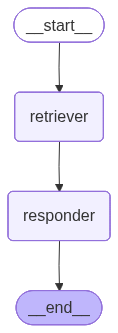

In [19]:
# -----------------------------
# 4. Build LangGraph
# -----------------------------
builder = StateGraph(RAGstate)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)

builder.set_entry_point("retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()

graph

In [27]:
# -----------------------------
# 5. Run the Agentic RAG
# -----------------------------

if __name__ == "__main__":
    user_question = "What is the concept of agent loop in autonomous agents?"
    initial_state = RAGstate(question=user_question)
    final_state = graph.invoke(initial_state)

    print("\n Final Answer:\n", final_state['answer'])


 Final Answer:
 The concept of the agent loop in autonomous agents refers to the iterative process through which agents operate and improve their performance over time. This loop typically consists of several key components: 

1. **Action**: The agent takes an action based on its current goals and knowledge.

2. **Observation**: After executing an action, the agent observes the outcomes or results of that action in its environment.

3. **Reflection**: The agent reflects on the outcomes, assessing whether its action was successful or not, which allows it to learn from the experience.

4. **Memory**: The agent stores relevant experiences and information from past interactions to inform future decisions.

5. **Planning**: Based on its reflections and past memories, the agent plans its next actions to better align with its goals.

By cycling through these steps, the agent can adapt and optimize its behavior over time, effectively utilizing self-reflection to remedy mistakes and improve it